In [1]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
from functions import directionOfEffect, harmonic_sum
from pyspark.ml.functions import array_to_vector, vector_to_array

spark = SparkSession.builder.config("spark.sql.pivotMaxValues", "200000").getOrCreate()

24/11/19 17:06:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
platform_v = "24.09"

mophe_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/mousePhenotypes"
)
mophe = spark.read.parquet(mophe_path)

target_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/targets/"
)
target = spark.read.parquet(target_path)

mopheScore_path = "gs://ot-team/jroldan/20230825_mousePheScores.csv"
mopheScore = spark.read.csv(mopheScore_path, header=True)

In [3]:
safetyLiability = (
    target.select("id", F.explode_outer(F.col("safetyLiabilities")).alias("safeLiable"))
    .select("id", "safeLiable.*")
    .filter(~F.col("datasource").isin(["Brennan et al. (2024)", "PharmGKB"]))
    .select("id", "event")
    .groupBy("id")
    .agg(F.count("event").alias("safetyLiabl"))
    .sort(F.col("safetyLiabl").asc())
)
n = safetyLiability.count()
print("There are", n, "targets with safety liabilities excluding Brennan 2024 and PGx")

constr = (
    target.select("id", F.explode_outer(F.col("constraint")).alias("genConstraint"))
    .select("id", "genConstraint.*")
    .filter(
        F.col("constraintType")
        == "lof"
        # ).sort(F.col("upperRank").desc()
    )
    .select(
        "id",
        "upperRank",
        "oe",
        F.col("score").alias("scoreConstraint"),
    )
)
minUpperRank = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .groupBy("constraintType")
    .agg(F.min("upperRank").alias("upperRank"))
    .select("upperRank")
    .rdd.flatMap(lambda x: x)
    .collect()[0]
)

maxUpperRank = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .groupBy("constraintType")
    .agg(F.max("upperRank").alias("upperRank"))
    .select("upperRank")
    .rdd.flatMap(lambda x: x)
    .collect()[0]
)

loftolerance = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("constr_id"), F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .withColumn(
        "cal_score",
        F.lit(
            (2 * ((F.col("upperRank") - minUpperRank) / (maxUpperRank - minUpperRank)))
            - 1
        ),
    )
    .selectExpr("constr_id as id", "cal_score", "constraintType")
)
mousePhenoScoreFilter = mopheScore.select(
    F.col("id").alias("idLabel"),
    F.col("label").alias("phenoLabel"),
    F.col("score"),
).withColumn(
    "curatedScore",
    F.when(F.col("score") == 0.0, F.lit(0)).otherwise(F.lit(F.col("score"))),
)
scoreCalc_list = (
    mophe.select(
        "targetFromSourceId",
        F.explode_outer(F.col("modelPhenotypeClasses.id")).alias("id"),
    )
    .join(mousePhenoScoreFilter, F.col("id") == mousePhenoScoreFilter.idLabel, "left")
    ##.na.drop(subset=['scoreRevisado3'])
    .withColumn("score", F.col("curatedScore").cast(FloatType()))
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("score")).alias("score"))
    #    .join(constr.select("constr_id","upperRank"), constr.constr_id == F.col("targetFromSourceId"),"left")
)

safetyWOToxCast = (
    target.select("id", F.explode_outer(F.col("safetyLiabilities")).alias("safeLiable"))
    .filter(
        ~F.col("safeLiable.datasource").isin(
            ["ToxCast", "Brennan et al. (2024)", "PharmGKB"]
        )
    )
    .select("id", "safeLiable.*")
    .select("id", "event")
    .groupBy("id")
    .agg(F.count("event").alias("noToxCast"))
    .sort(F.col("noToxCast").asc())
)

n = safetyWOToxCast.count()
print(
    "There are",
    n,
    " targets with safety liabilities excluding ToxCast, Brennan 2024 and PGx",
)

approvedTargets = spark.read.csv(
    "gs://ot-team/jroldan/2013-2022_approvals.csv", header=True
).drop("_c0")
approved = approvedTargets.select("targetIds")


def remove_all_whitespace(col):
    return F.regexp_replace(col, "\\s+", "")


approvedTargets = (
    approved.withColumn("targets", (F.explode(F.split(F.col("targetIds"), ";"))))
    .withColumn("trimmed", F.trim(F.col("targets")))
    .selectExpr("trimmed as id")
    .withColumn("approved", F.lit("approved"))
    .distinct()
)

df_py = scoreCalc_list.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised

## convert pandas to spark dataframe
df = spark.createDataFrame(df_py).withColumnRenamed("targetFromSourceId", "id")

platform_v = "24.09"
evidences = spark.read.parquet(
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/evidence"
).filter(
    F.col("datasourceId").isin(
        [
            "ot_genetics_portal",
            "gene_burden",
            "eva",
            "eva_somatic",
            "gene2phenotype",
            "orphanet",
            "cancer_gene_census",
            "intogen",
            "impc",
            "chembl",
        ]
    )
)

dataset = directionOfEffect(evidences, platform_v).persist()

drugWarning_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/drugWarnings"
)
drugwarnings = spark.read.parquet(drugWarning_path)

#### filter Drugs by inhibitors (LoF)
lofDrugs = (
    dataset.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "drugId", "homogenized")
    .filter(F.col("homogenized") == "LoF_protect")
    .groupBy("targetId", "drugId")
    .count()
)

lofDrugsWarnings = lofDrugs.join(
    drugwarnings.withColumn("drugId", F.explode_outer("chemblIds")).select(
        "drugId", "toxicityClass", "warningType"
    ),
    on="drugId",
    how="left",
).distinct()

suffix_bbw = "_BBW"

lofDrugWarningBBX = (
    lofDrugsWarnings.filter(F.col("warningType") == "Black Box Warning")
    .groupBy("targetId")
    .pivot("toxicityClass")
    .agg(F.collect_set("warningType"))
)

array_columns = lofDrugWarningBBX.columns[1:]

# The value to check in the arrays
value_to_check = "Black Box Warning"

# Create a new DataFrame with transformed columns
df_transformed = lofDrugWarningBBX

for col_name in array_columns:
    new_col_name = f"{col_name}_BBW"
    df_transformed = df_transformed.withColumn(
        new_col_name,
        F.when(F.array_contains(F.col(col_name), value_to_check), 1).otherwise(0),
    )

lofDrugWarningBBX_format = df_transformed.drop(*array_columns).withColumn(
    "allBBW", F.lit(1)
)

lofDrugWarningWD = (
    lofDrugsWarnings.filter(F.col("warningType") == "Withdrawn")
    .groupBy("targetId")
    .pivot("toxicityClass")
    .agg(F.collect_set("warningType"))
)

array_columns = lofDrugWarningWD.columns[1:]

# The value to check in the arrays
value_to_check = "Withdrawn"

# Create a new DataFrame with transformed columns
df_transformed = lofDrugWarningWD

for col_name in array_columns:
    new_col_name = f"{col_name}_WD"
    df_transformed = df_transformed.withColumn(
        new_col_name,
        F.when(F.array_contains(F.col(col_name), value_to_check), 1).otherwise(0),
    )

lofDrugWarningWD_format = df_transformed.drop(*array_columns).withColumn(
    "allWD", F.lit(1)
)

lofDrugsBBw_WD = (
    lofDrugWarningWD_format.join(lofDrugWarningBBX_format, on="targetId", how="outer")
    .withColumn("bwwAndwd", F.lit(1))
    .na.fill(0)
)

### make dataset for comparisons
df_comparisons = (
    df.join(loftolerance, on="id", how="left")
    .join(safetyLiability, on="id", how="left")
    .join(safetyWOToxCast, on="id", how="left")
    .join(approvedTargets, on="id", how="left")
    .join(lofDrugsBBw_WD.withColumnRenamed("targetId", "id"), on="id", how="left")
    .withColumn("allBBW", F.when(F.col("allBBW") == 1, F.lit(1)).otherwise(F.lit(0)))
    .withColumn("allWD", F.when(F.col("allWD") == 1, F.lit(1)).otherwise(F.lit(0)))
    .persist()
)

#### Make deciles for harmonic sum
# Calculate quartiles or deciles
quantiles = df_comparisons.approxQuantile(
    "harmonicSumNorm", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.01
)
# Define quartile or decile bins
bins = [float("-inf")] + quantiles + [float("inf")]
window_spec = Window.orderBy("harmonicSumNorm")
df_with_labels = (
    df_comparisons.withColumn(
        "decilesHarmonicSumNorm",
        F.when(F.col("harmonicSumNorm").isNull(), None).otherwise(
            sum(
                F.when(F.col("harmonicSumNorm") >= bin_val, 1).otherwise(0)
                for bin_val in bins
            )
        ),
    )
    .withColumn(
        "safetyLiabilities",
        F.when(F.col("safetyLiabl").isNotNull(), F.lit(1)).otherwise(0),
    )
    .withColumn(
        "noToxCastLiab", F.when(F.col("noToxCast").isNotNull(), F.lit(1)).otherwise(0)
    )
    .drop("nr", "noToxCast")
)

## rare diseases
rare = [
    "eva",
    "cancer_gene_census",
    "eva_somatic",
    "orphanet",
    "genomics_england",
    "gene2phenotype",
    "intogen",
]

## common diseases
common = ["ot_genetics_portal", "gene_burden"]

diseaseTypes = (  ### association of target with diseases caused by (LoF risk)
    dataset.withColumn(
        "diseaseType",
        F.when(F.col("datasourceId").isin(rare), F.lit("rare")).when(
            F.col("datasourceId").isin(common), F.lit("common")
        ),
    )
    .filter(
        (
            F.col("homogenized") == "LoF_risk"
        )  ### filter by diseases caused by targets with LoF mutations
        & (F.col("diseaseType").isNotNull())
    )
    .groupBy("targetId", "diseaseId")
    .agg(
        F.count("targetId").alias("nr"),
        F.collect_set("diseaseType").alias("diseaseType"),
    )
    .withColumn("bivalent", F.size(F.col("diseaseType")))
    # .filter(F.col("bivalent") == 1)
).persist()

scoring = (
    diseaseTypes.groupBy("targetId")
    .agg(F.flatten(F.collect_set("diseaseType")).alias("diseaseType"))
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.25),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(F.size(F.col("diseaseType")) == 2, F.lit(0.7))
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0)),
    )
)

phenoDiseases = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel", "targetFromSourceId")
    .withColumnRenamed("targetFromSourceId", "targetId")
    .join(scoring, on="targetId", how="right")
    .withColumn("typesOfDiseases", F.explode_outer(F.col("diseaseType")))
    .groupBy("modelPhenotypeLabel")
    .agg(F.collect_set("typesOfDiseases").alias("diseaseType"))
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.2),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(
            (F.size(F.col("diseaseType")) == 2)
            & (F.col("modelPhenotypeLabel").isNotNull()),
            F.lit(0.6),
        )
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0))
        .otherwise(F.lit(0)),
    )
)

scoreDiseases1 = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel")
    .join(phenoDiseases, on="modelPhenotypeLabel", how="right")
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("scoreFromDisease")).alias("score"))
)

df_py = scoreDiseases1.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))
# maximumScore = max(values)

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised


## convert pandas to spark dataframe
df_scoreDisease1 = (
    spark.createDataFrame(df_py)
    .withColumnRenamed("targetFromSourceId", "id")
    .selectExpr(
        "id",
        "score as scoreDiseases1",
        "harmonicSumNorm as dis1HarmSumNorm",
    )
    .filter(F.col("id").isNotNull())
)

df_comparisons2 = df_comparisons.join(df_scoreDisease1, on="id", how="left")

phenoDiseases2 = (
    evidences.filter(F.col("datasourceId") == "impc")
    .withColumn(
        "explotedPhenotypes",
        F.explode_outer(F.col("diseaseModelAssociatedModelPhenotypes")),
    )
    .select("targetId", "diseaseId", "explotedPhenotypes")
    .join(
        diseaseTypes.select("diseaseId", "diseaseType", "bivalent"),
        on="diseaseId",
        how="left",
    )
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.2),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(
            (F.size(F.col("diseaseType")) == 2),
            F.lit(0.6),
        )
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0))
        .otherwise(F.lit(0)),
    )
    .groupBy("explotedPhenotypes")
    .agg(F.collect_set("scoreFromDisease").alias("scores"))
    .withColumn("NrScores", F.size("scores"))
    .withColumn(
        "average",
        F.expr("aggregate(scores, 0D, (acc, x) -> acc + x, acc -> acc / size(scores))"),
    )
).persist()

scoreDiseases2 = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel")
    .join(
        phenoDiseases2.selectExpr(
            "explotedPhenotypes.label as modelPhenotypeLabel", "average"
        ),
        on="modelPhenotypeLabel",
        how="right",
    )
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("average")).alias("score"))
)

df_py = scoreDiseases2.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))
# maximumScore = max(values)

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised


## convert pandas to spark dataframe
df_scoreDisease2 = (
    spark.createDataFrame(df_py)
    .withColumnRenamed("targetFromSourceId", "id")
    .selectExpr(
        "id",
        "score as scoreDiseases2",
        "harmonicSumNorm as dis2HarmSumNorm",
    )
    .filter(F.col("id").isNotNull())
)

df_comparisons3 = df_comparisons2.join(df_scoreDisease2, on="id", how="left")

There are 503 targets with safety liabilities excluding Brennan 2024 and PGx


There are 262  targets with safety liabilities excluding ToxCast, Brennan 2024 and PGx


24/11/19 09:13:09 WARN CacheManager: Asked to cache already cached data.        


In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
import umap  # if you're using UMAP with PySpark, make sure you have the Spark UMAP library or UMAP Python bindings
from pyspark.sql import functions as F

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!pip3 install xlrd

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [7]:
all_bbw = (
    mophe.groupBy("targetFromSourceId")
    .pivot("modelPhenotypeLabel")
    .agg(F.size(F.collect_set("modelPhenotypeLabel")))
    .fillna(0)
    .join(
        df_comparisons3.select(
            "id",
            "allBBW",
        ).withColumnRenamed("id", "targetFromSourceId"),
        on="targetFromSourceId",
        how="left",
    )
).persist()
all_bbw_pd = all_bbw.toPandas()
### tranform into numpy array
data = np.array(all_bbw_pd)

24/11/19 09:19:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_238_46 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_127_151 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_127_47 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_306_89 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_306_25 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_306_12 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_127_99 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_127_64 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_306_140 !
24/11/19 09:21:21 WARN BlockManagerMasterEndpoint: No mor

#### SVM implementation

In [9]:
# Assuming your data matrix is stored in a variable `data`
# Extract the feature matrix and target vector
# The last column is the outcome, adjust indexing as necessary
X = data[:, 1:-1]  # All columns except the first and the last one
y = data[:, -1]  # The last column is the 'outcome'

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

###convert y_train to Integer Type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Scale features (optional since data is 0-1, but good practice in general)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel="linear", class_weight="balanced", random_state=42)
# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model accuracy:", accuracy)
print("Classification report:\n", report)

# Access feature coefficients for a linear SVM
feature_coefficients = svm_model.coef_

print("Feature coefficients (weights):", feature_coefficients)

# For binary classification
for i, coef in enumerate(feature_coefficients[0]):
    print(f"Feature {i}: {coef}")

Model accuracy: 0.8998798558269924
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      2443
           1       0.02      0.09      0.04        54

    accuracy                           0.90      2497
   macro avg       0.50      0.51      0.49      2497
weighted avg       0.96      0.90      0.93      2497

Feature coefficients (weights): [[ 1.09741589e-17 -1.22659243e-03 -1.32949698e-15 ...  3.30824918e-02
   6.33279101e-16 -3.19791360e-16]]
Feature 0: 1.0974158864626715e-17
Feature 1: -0.0012265924315599385
Feature 2: -1.329496984779719e-15
Feature 3: 0.0
Feature 4: -9.4738009348257e-16
Feature 5: -9.369793759232345e-17
Feature 6: -5.335604530355871e-16
Feature 7: 0.0
Feature 8: -4.1490553668536295e-16
Feature 9: 1.9419924381699344e-16
Feature 10: 0.010030818175383352
Feature 11: 0.006355011093385801
Feature 12: -2.013134735409823e-16
Feature 13: 1.886079793321678e-16
Feature 14: -0.007224567975757135
Featur

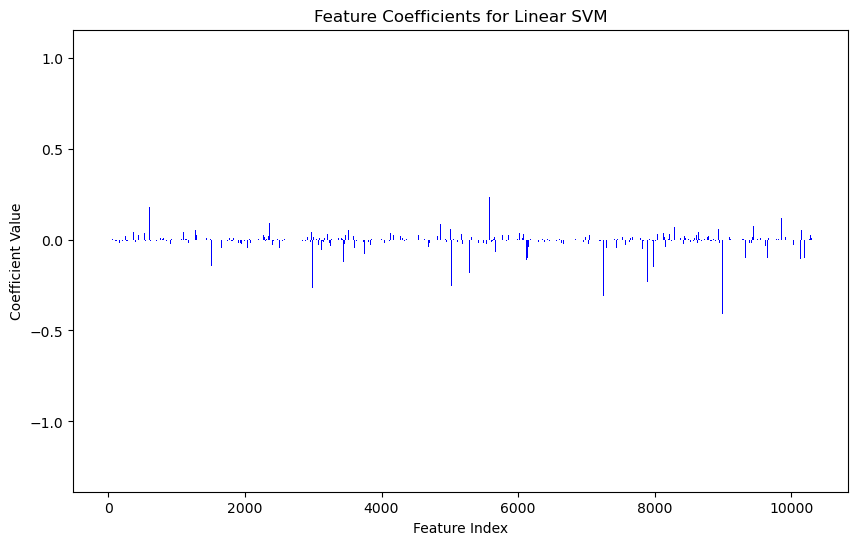

In [10]:
import matplotlib.pyplot as plt

# Plot feature weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coefficients[0])), feature_coefficients[0], color="blue")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Feature Coefficients for Linear SVM")
plt.show()

In [11]:
# Rank features by absolute coefficient value
feature_importance = np.abs(feature_coefficients[0])
sorted_indices = np.argsort(feature_importance)[::-1]  # Sort in descending order

print("Feature importance ranking:")
for idx in sorted_indices:
    print(f"Feature {idx}: Coefficient {feature_coefficients[0][idx]}")

Feature importance ranking:
Feature 7824: Coefficient -1.2708730632178706
Feature 7185: Coefficient -1.1259213090723486
Feature 6688: Coefficient -1.0593430294038453
Feature 9009: Coefficient 1.0377605582691298
Feature 5125: Coefficient -1.0121976136253816
Feature 7663: Coefficient -0.9477923612772193
Feature 9314: Coefficient -0.9218015514113931
Feature 6560: Coefficient -0.8410749220423127
Feature 5495: Coefficient -0.7985059792591431
Feature 8000: Coefficient -0.7727319668676135
Feature 8067: Coefficient -0.7229691462393112
Feature 2731: Coefficient 0.7062246572016223
Feature 7443: Coefficient -0.6951340454632736
Feature 5160: Coefficient -0.6893958503305727
Feature 5738: Coefficient -0.6884797463287293
Feature 5681: Coefficient -0.6785271011802481
Feature 8770: Coefficient -0.6563979217121094
Feature 7856: Coefficient -0.6545392692014667
Feature 3309: Coefficient 0.594646033127161
Feature 5156: Coefficient -0.582788151473032
Feature 3654: Coefficient 0.5793200700089478
Feature 8147

In [8]:
# Extract features and target
X = all_bbw_pd.drop(columns=["targetFromSourceId", "allBBW"])  # Features only
y = all_bbw_pd["allBBW"]

# Store feature names
feature_names = all_bbw_pd.drop(
    columns=["targetFromSourceId", "allBBW"]
).columns.tolist()

# Retrieve feature coefficients
feature_coefficients = svm_model.coef_[0]

# Map feature names to coefficients
feature_importance = {
    feature_names[i]: feature_coefficients[i] for i in range(len(feature_names))
}

# Sort features by the actual coefficient value in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print(
    "Feature importance ranking (sorted by actual weight, with positive as risk and negative as protective):"
)
for feature, coef in sorted_features:
    print(f"{feature}: {coef}")

NameError: name 'svm_model' is not defined

These results indicate that while your model has a high overall accuracy (93.99%), it struggles to correctly predict the minority class (1), as evidenced by the low precision, recall, and F1-score for that class. This is typical for imbalanced datasets where accuracy can be misleading, as the model may achieve high accuracy by predominantly predicting the majority class (0).

Here's a closer look at what each metric shows:

Precision for Class 1 (0.04): Of all predictions made for the minority class, only 4% were correct. This low precision means there are many false positives for class 1.

Recall for Class 1 (0.07): Only 7% of actual occurrences of class 1 were correctly identified by the model. Low recall indicates the model is missing many of the minority class cases, suggesting it is biased towards the majority class.

F1-Score for Class 1 (0.05): F1-score is the harmonic mean of precision and recall. A low F1-score shows that the model is not effectively balancing precision and recall for the minority class.


### Random Forest implementation

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np

In [14]:
# Initialize RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2443
           1       0.05      0.06      0.05        54

    accuracy                           0.96      2497
   macro avg       0.51      0.52      0.51      2497
weighted avg       0.96      0.96      0.96      2497

Confusion Matrix:
[[2385   58]
 [  51    3]]


#### Using SMOTE for random sampling 

In [15]:
# pip install imbalanced-learn

In [16]:
from imblearn.over_sampling import SMOTE

# Resample the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [17]:
# Initialize RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2447
           1       0.93      0.98      0.95      2438

    accuracy                           0.95      4885
   macro avg       0.95      0.95      0.95      4885
weighted avg       0.95      0.95      0.95      4885

Confusion Matrix:
[[2255  192]
 [  47 2391]]


In [18]:
# Assuming rf_model is already trained

# Store feature names
feature_names = (
    X.columns.tolist()
)  # Or replace with appropriate column names if using numpy arrays

# Retrieve feature importances from the trained RandomForest model
feature_importances = rf_model.feature_importances_

# Map feature names to importance scores
feature_importance = {
    feature_names[i]: feature_importances[i] for i in range(len(feature_names))
}

# Sort by importance (in descending order)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("Feature importance ranking:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Feature importance ranking:
no abnormal phenotype detected: 0.04102572559436818
male infertility: 0.016896647872694695
decreased body weight: 0.016514474629501882
hyperactivity: 0.012378900379929083
abnormal auditory brainstem response: 0.009391872235229774
abnormal spleen morphology: 0.009372942801953714
abnormal heart morphology: 0.00876179841336436
enlarged spleen: 0.00874691442504622
decreased body size: 0.008724611241825117
embryonic growth retardation: 0.008641849120501732
enlarged heart: 0.008601692676644209
abnormal retina morphology: 0.008278915049415409
increased circulating alanine transaminase level: 0.00811188259193688
impaired glucose tolerance: 0.008004273709961911
decreased exploration in new environment: 0.007993563707973135
cataract: 0.007525668369266154
decreased circulating glucose level: 0.007369526414053359
neonatal lethality, complete penetrance: 0.007245489289209608
abnormal gait: 0.0069987670018939775
abnormal skin morphology: 0.006935275704406164
decreased gri

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


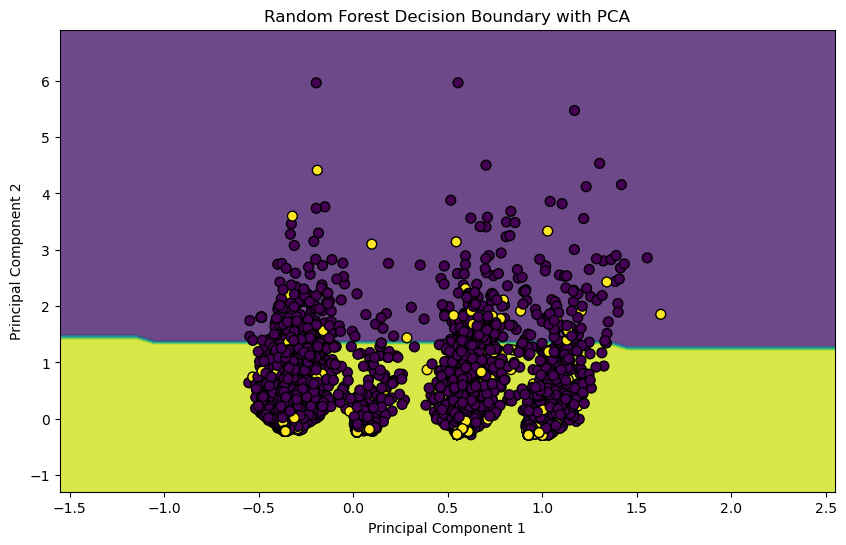

In [19]:
import numpy as np
from sklearn.decomposition import PCA

# Reduce the data to 2D for visualization (using PCA)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Create a mesh grid for the 2D plot
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Make predictions across the grid
Z = rf_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, edgecolors="k", marker="o", s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Random Forest Decision Boundary with PCA")
plt.show()

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


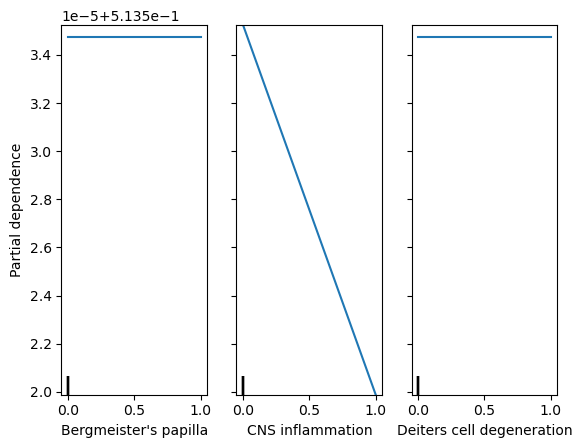

In [20]:
from sklearn.inspection import plot_partial_dependence

# Plot partial dependence for the top 3 important features
plot_partial_dependence(
    rf_model,
    X_train,
    features=[0, 1, 2],
    feature_names=feature_names,
    grid_resolution=50,
)
plt.show()

#### cross validation

In [21]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="accuracy")

# Print the cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.95266121 0.94677584 0.94703173 0.95368475 0.94778603]
Mean cross-validation score: 0.9495879112602397


#### plot decision tree

In [22]:
rf_model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

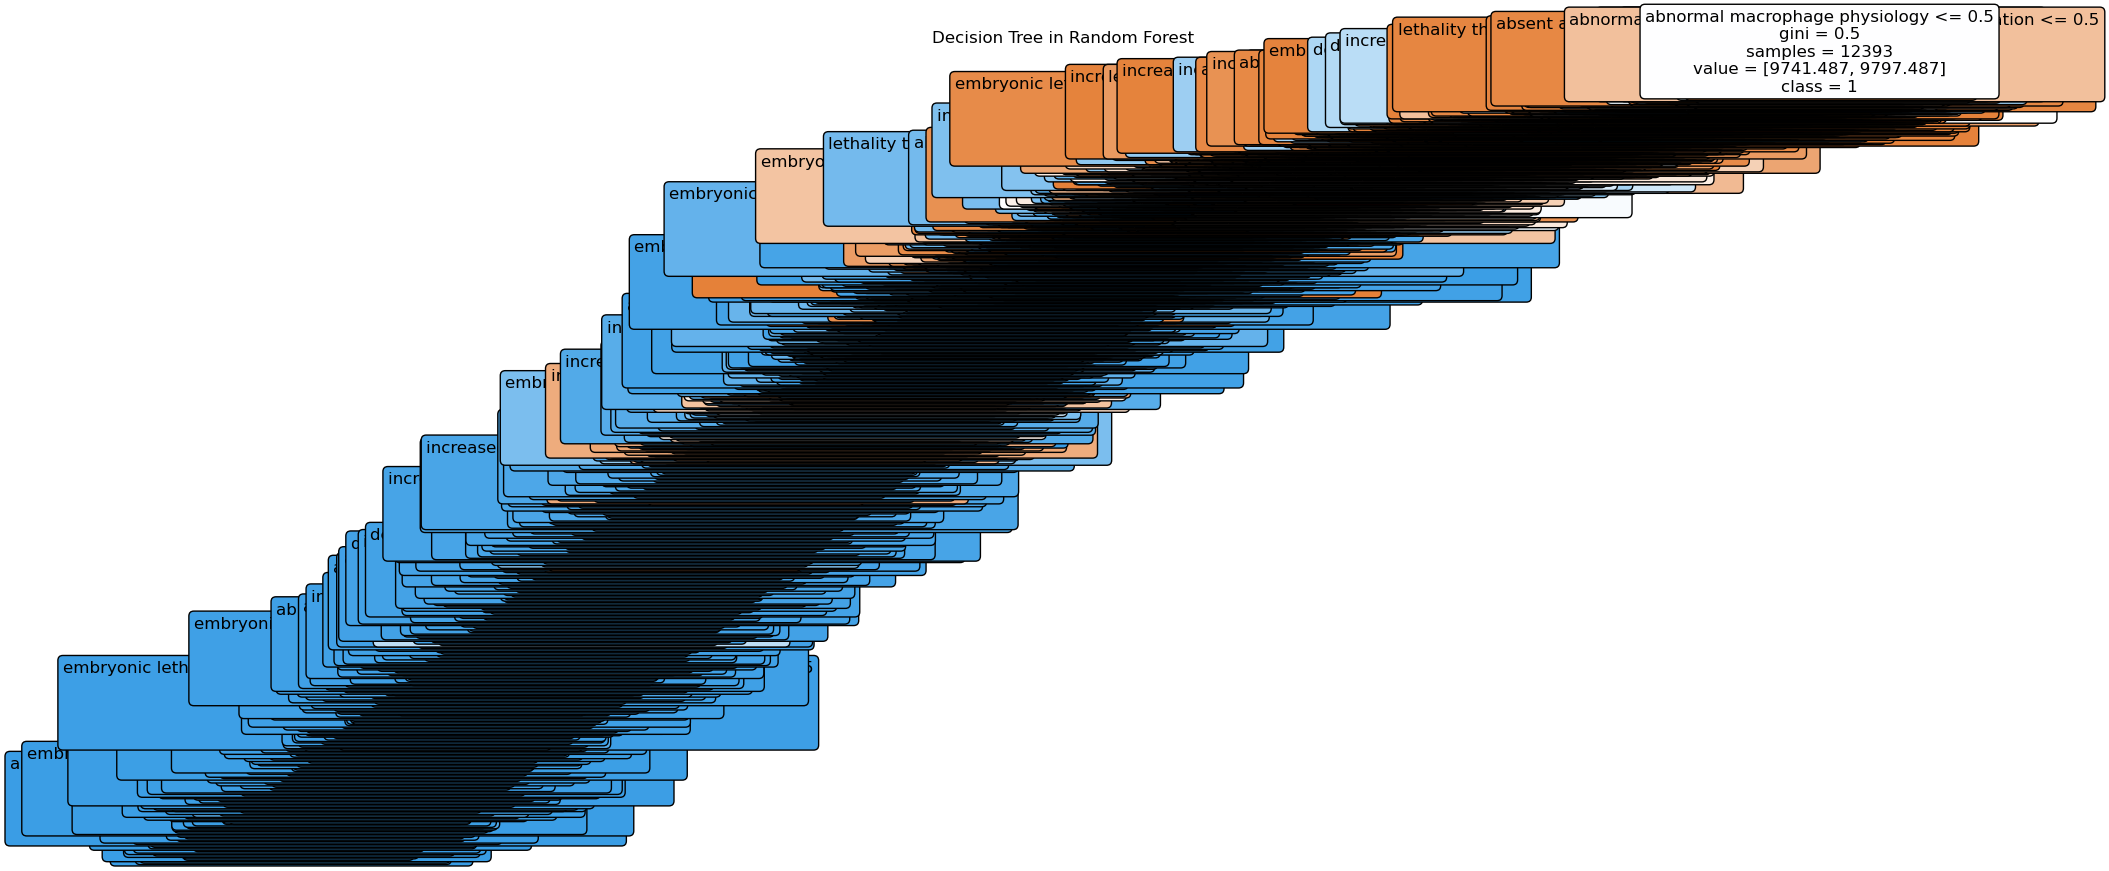

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Select the first tree in the Random Forest model
# You can replace 0 with any index to visualize another tree
tree_to_plot = rf_model.estimators_[0]  # This picks the first tree in the Random Forest

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_to_plot,
    filled=True,  # Color the nodes based on class
    feature_names=feature_names,  # Names of the features (columns)
    class_names=["0", "1"],  # Class labels for the target variable
    rounded=True,  # Rounded corners for clarity
    fontsize=12,
)  # Font size for better readability

plt.title("Decision Tree in Random Forest")
plt.show()

1. Univariate Feature Selection with Statistical Tests
You can use statistical tests to select features that have the strongest relationship with the target variable.
SelectKBest is a commonly used method for univariate feature selection, where you can choose the top k features based on statistical metrics such as ANOVA F-value or Chi-squared score.

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 100 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X, y)

# Get selected feature indices
selected_features = selector.get_support(indices=True)

In [25]:
selected_features

array([   81,   228,   243,   251,   252,   258,   425,   456,   495,
         583,   693,  1524,  1740,  1799,  1800,  1827,  2039,  2091,
        2252,  2391,  2471,  2697,  2701,  2811,  2972,  2980,  3408,
        3565,  3798,  3856,  3905,  4436,  4854,  4866,  4952,  5108,
        5263,  5266,  5345,  5359,  5574,  5876,  6085,  6124,  6186,
        6191,  6207,  6378,  6609,  6630,  6645,  7122,  7143,  7151,
        7166,  7208,  7364,  7528,  7546,  7553,  7648,  7653,  7693,
        8087,  8288,  8564,  8580,  8584,  8712,  8714,  8788,  9009,
        9145,  9162,  9226,  9230,  9272,  9285,  9286,  9292,  9297,
        9298,  9301,  9341,  9387,  9389,  9390,  9391,  9435,  9443,
        9544,  9747,  9924,  9951,  9958, 10019, 10192, 10206, 10219,
       10224])

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import pandas as pd

# Select the scoring function (choose either f_classif or chi2 based on your data)
score_func = f_classif  # Use f_classif for ANOVA F-value
# score_func = chi2  # Uncomment to use chi2 if your data is non-negative and categorical

# Initialize SelectKBest with top 100 features
selector = SelectKBest(score_func=score_func, k=100)

# Fit the selector to the data and target
selector.fit(X, y)

# Retrieve the scores and the selected feature indices
scores = selector.scores_  # All feature scores
selected_indices = selector.get_support(
    indices=True
)  # Indices of the top 100 selected features

# Retrieve feature names for the top 100 features
selected_feature_names = [feature_names[i] for i in selected_indices]
selected_scores = scores[selected_indices]

# Combine feature names and their scores into a DataFrame for easier interpretation
top_features_df = pd.DataFrame(
    {"Feature": selected_feature_names, "Score": selected_scores}
).sort_values(by="Score", ascending=False)

print("Top 100 Features with Scores:")
print(top_features_df)

Top 100 Features with Scores:
                                              Feature       Score
64                           increased renin activity  258.876587
4   abnormal adrenal gland zona glomerulosa morpho...  182.239456
87                                     pyelonephritis  143.745773
71                     no abnormal phenotype detected  113.945694
53         impaired behavioral response to xenobiotic  110.158081
..                                                ...         ...
81            premature squamoparietal suture closure   45.055508
80    premature sphenooccipital synchondrosis closure   45.055508
79    premature maxillary-premaxillary suture closure   45.055508
72           partial loss of secondary muscle spindle   45.055508
77              premature craniofacial suture closure   45.055508

[100 rows x 2 columns]


In [27]:
# Use the selected indices to create a new feature set
X_selected = selector.transform(X)  # Transform X to contain only the top 100 features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_selected, y)

# Predict on the test set (assuming X_test_selected and y_test are defined similarly)
y_pred_rf = rf_model.predict(X_selected)

# Evaluate the model
print("Random Forest Model Performance:")
print(classification_report(y, y_pred_rf))

# Retrieve feature importances
rf_importances = rf_model.feature_importances_

# Map importances to feature names
top_features_rf = pd.DataFrame(
    {"Feature": selected_feature_names, "Importance": rf_importances}
).sort_values(by="Importance", ascending=False)

print("Top Features in Random Forest Model:")
print(top_features_rf.head(10))  # View the top 10 features

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12212
           1       0.96      0.30      0.46       272

    accuracy                           0.98     12484
   macro avg       0.97      0.65      0.73     12484
weighted avg       0.98      0.98      0.98     12484

Top Features in Random Forest Model:
                                      Feature  Importance
71             no abnormal phenotype detected    0.046603
78                            premature death    0.040358
76   postnatal lethality, complete penetrance    0.039759
40                       decreased heart rate    0.026428
64                   increased renin activity    0.025570
11                        abnormal heart rate    0.023787
32                           cardiac fibrosis    0.023578
9   abnormal cardiovascular system physiology    0.022460
34                   congestive heart failure    0.022317
0    abnormal GABA-medi

In [28]:
#!pip install xgboost
from xgboost import XGBClassifier

In [29]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss"
)
xgb_model.fit(X_selected, y)

# Predict on the test set (assuming X_test_selected and y_test are defined similarly)
y_pred_xgb = xgb_model.predict(X_selected)

# Evaluate the model
print("XGBoost Model Performance:")
print(classification_report(y, y_pred_xgb))

# Retrieve feature importances from the XGBoost model
xgb_importances = xgb_model.feature_importances_

# Map importances to feature names
top_features_xgb = pd.DataFrame(
    {"Feature": selected_feature_names, "Importance": xgb_importances}
).sort_values(by="Importance", ascending=False)

print("Top Features in XGBoost Model:")
print(top_features_xgb.head(10))  # View the top 10 features

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12212
           1       0.93      0.14      0.24       272

    accuracy                           0.98     12484
   macro avg       0.95      0.57      0.62     12484
weighted avg       0.98      0.98      0.97     12484

Top Features in XGBoost Model:
                                              Feature  Importance
26           abnormal sympathetic ganglion morphology    0.092998
64                           increased renin activity    0.072505
71                     no abnormal phenotype detected    0.056900
25  abnormal response/metabolism to endogenous com...    0.055355
11                                abnormal heart rate    0.050112
53         impaired behavioral response to xenobiotic    0.044226
39                  decreased circulating renin level    0.043312
42      decreased susceptibility to induced arthritis    0.042248
34                   

/home/juanr/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:52:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [30]:
X100 = shap.utils.sample(X_selected, 100)

NameError: name 'shap' is not defined

In [46]:
X1, y1 = shap.datasets.california(n_points=1000)

In [50]:
y1

array([1.369  , 2.413  , 2.007  , 0.725  , 4.6    , 1.2    , 2.47   ,
       3.369  , 3.397  , 2.656  , 2.379  , 0.922  , 0.795  , 1.375  ,
       2.201  , 2.761  , 3.953  , 3.     , 1.827  , 3.864  , 1.314  ,
       0.742  , 2.31   , 3.941  , 1.761  , 1.734  , 2.021  , 1.708  ,
       0.926  , 0.57   , 4.657  , 3.726  , 4.     , 1.539  , 1.     ,
       1.587  , 1.421  , 1.396  , 3.197  , 1.313  , 1.107  , 0.849  ,
       0.704  , 2.76   , 1.58   , 0.542  , 1.232  , 1.162  , 1.592  ,
       2.155  , 2.781  , 0.66   , 2.929  , 1.712  , 2.75   , 0.962  ,
       5.00001, 1.676  , 1.829  , 2.231  , 1.733  , 1.891  , 1.177  ,
       2.468  , 0.618  , 0.934  , 0.557  , 3.905  , 2.03   , 0.889  ,
       5.00001, 1.703  , 1.55   , 0.579  , 5.00001, 1.083  , 3.506  ,
       2.032  , 2.214  , 1.553  , 2.706  , 2.     , 0.875  , 2.045  ,
       1.969  , 1.839  , 0.786  , 1.458  , 0.767  , 0.985  , 2.217  ,
       1.713  , 0.618  , 2.747  , 0.75   , 2.042  , 3.75   , 2.408  ,
       1.391  , 3.90

In [49]:
X.columns

Index(['Bergmeister's papilla', 'CNS inflammation',
       'Deiters cell degeneration',
       'Ebstein's malformation of tricuspid valve', 'Harderian gland atrophy',
       'Harderian gland hyperplasia', 'Harderian gland hypertrophy',
       'L5 dorsal root ganglion hypertrophy', 'Lafora bodies', 'Lewy bodies',
       ...
       'wide ribs', 'wide sagittal suture', 'wide sternum', 'wounding',
       'wrinkled skin', 'xanthoma', 'xerostomia', 'xiphoid process foramen',
       'yellow coat color', 'zygomatic arch hypoplasia'],
      dtype='object', length=10313)

In [45]:
shap.partial_dependence_plot(
    "MedInc",
    y_pred_xgb,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

ValueError: Could not find feature named: MedInc

#### Alternative" using SHAP for interpretability

In [30]:
# !pip install shap

In [41]:
shap.plots.bar(shap_values)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [42]:
shap.datasets.adult(display=True)[0].values

array([[39.0, ' State-gov', 13.0, ..., 0.0, 40.0, ' United-States'],
       [50.0, ' Self-emp-not-inc', 13.0, ..., 0.0, 13.0,
        ' United-States'],
       [38.0, ' Private', 9.0, ..., 0.0, 40.0, ' United-States'],
       ...,
       [58.0, ' Private', 9.0, ..., 0.0, 40.0, ' United-States'],
       [22.0, ' Private', 9.0, ..., 0.0, 20.0, ' United-States'],
       [52.0, ' Self-emp-inc', 9.0, ..., 0.0, 40.0, ' United-States']],
      dtype=object)

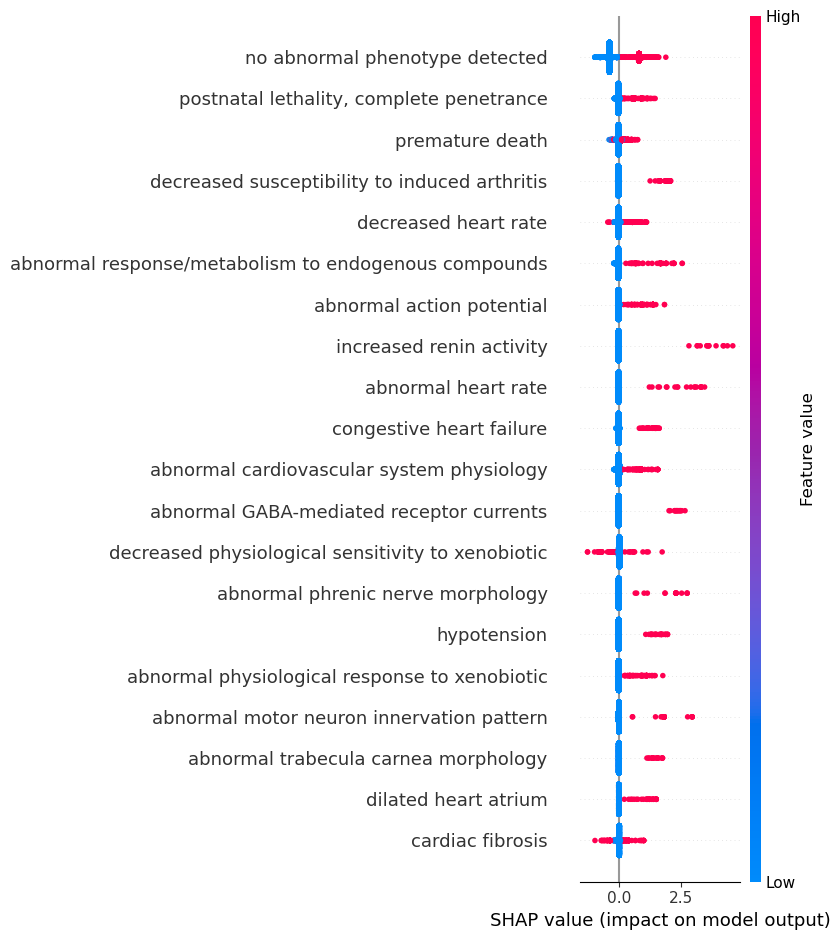

In [31]:
import shap

# Explain predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_selected)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_selected, feature_names=selected_feature_names)

#### contienen valore duplicados del random resampling?

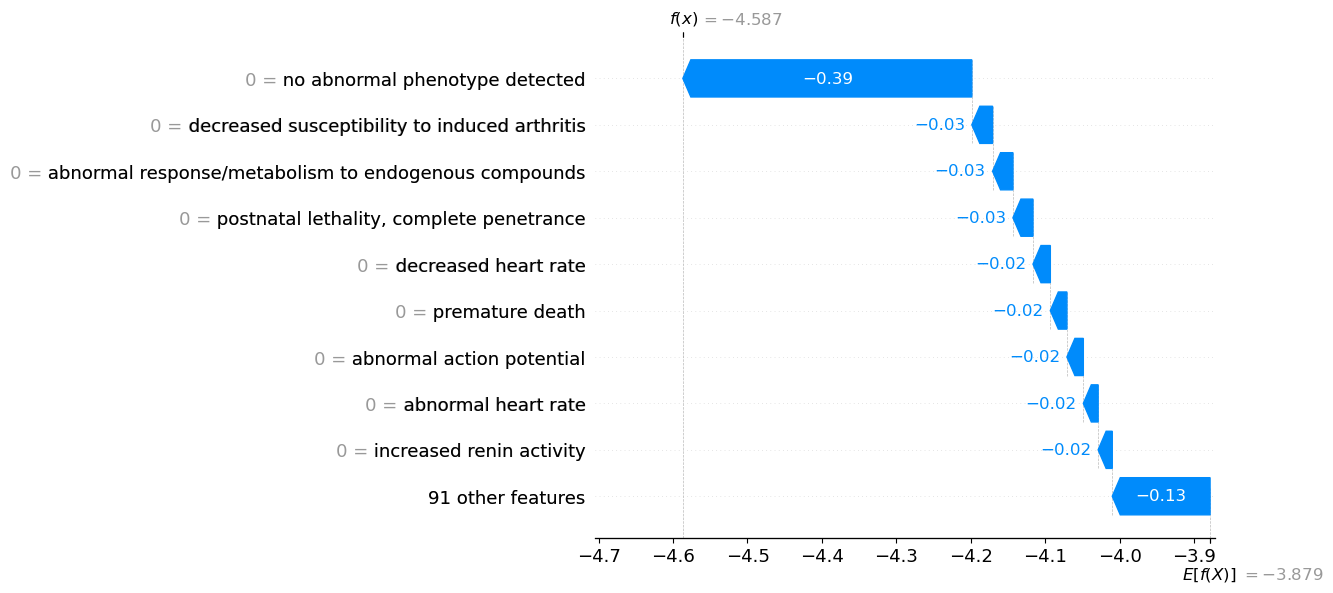

In [55]:
import shap

# Explain predictions using SHAP for XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_selected)

# Choose an observation to explain
observation_index = 0  # Select the first instance, change as needed
shap_waterfall = shap_values[observation_index]

# Assign the feature names to the SHAP values object for display
shap_waterfall.feature_names = (
    selected_feature_names  # Map feature names from SelectKBest
)

# Generate the waterfall plot
shap.plots.waterfall(shap_waterfall)

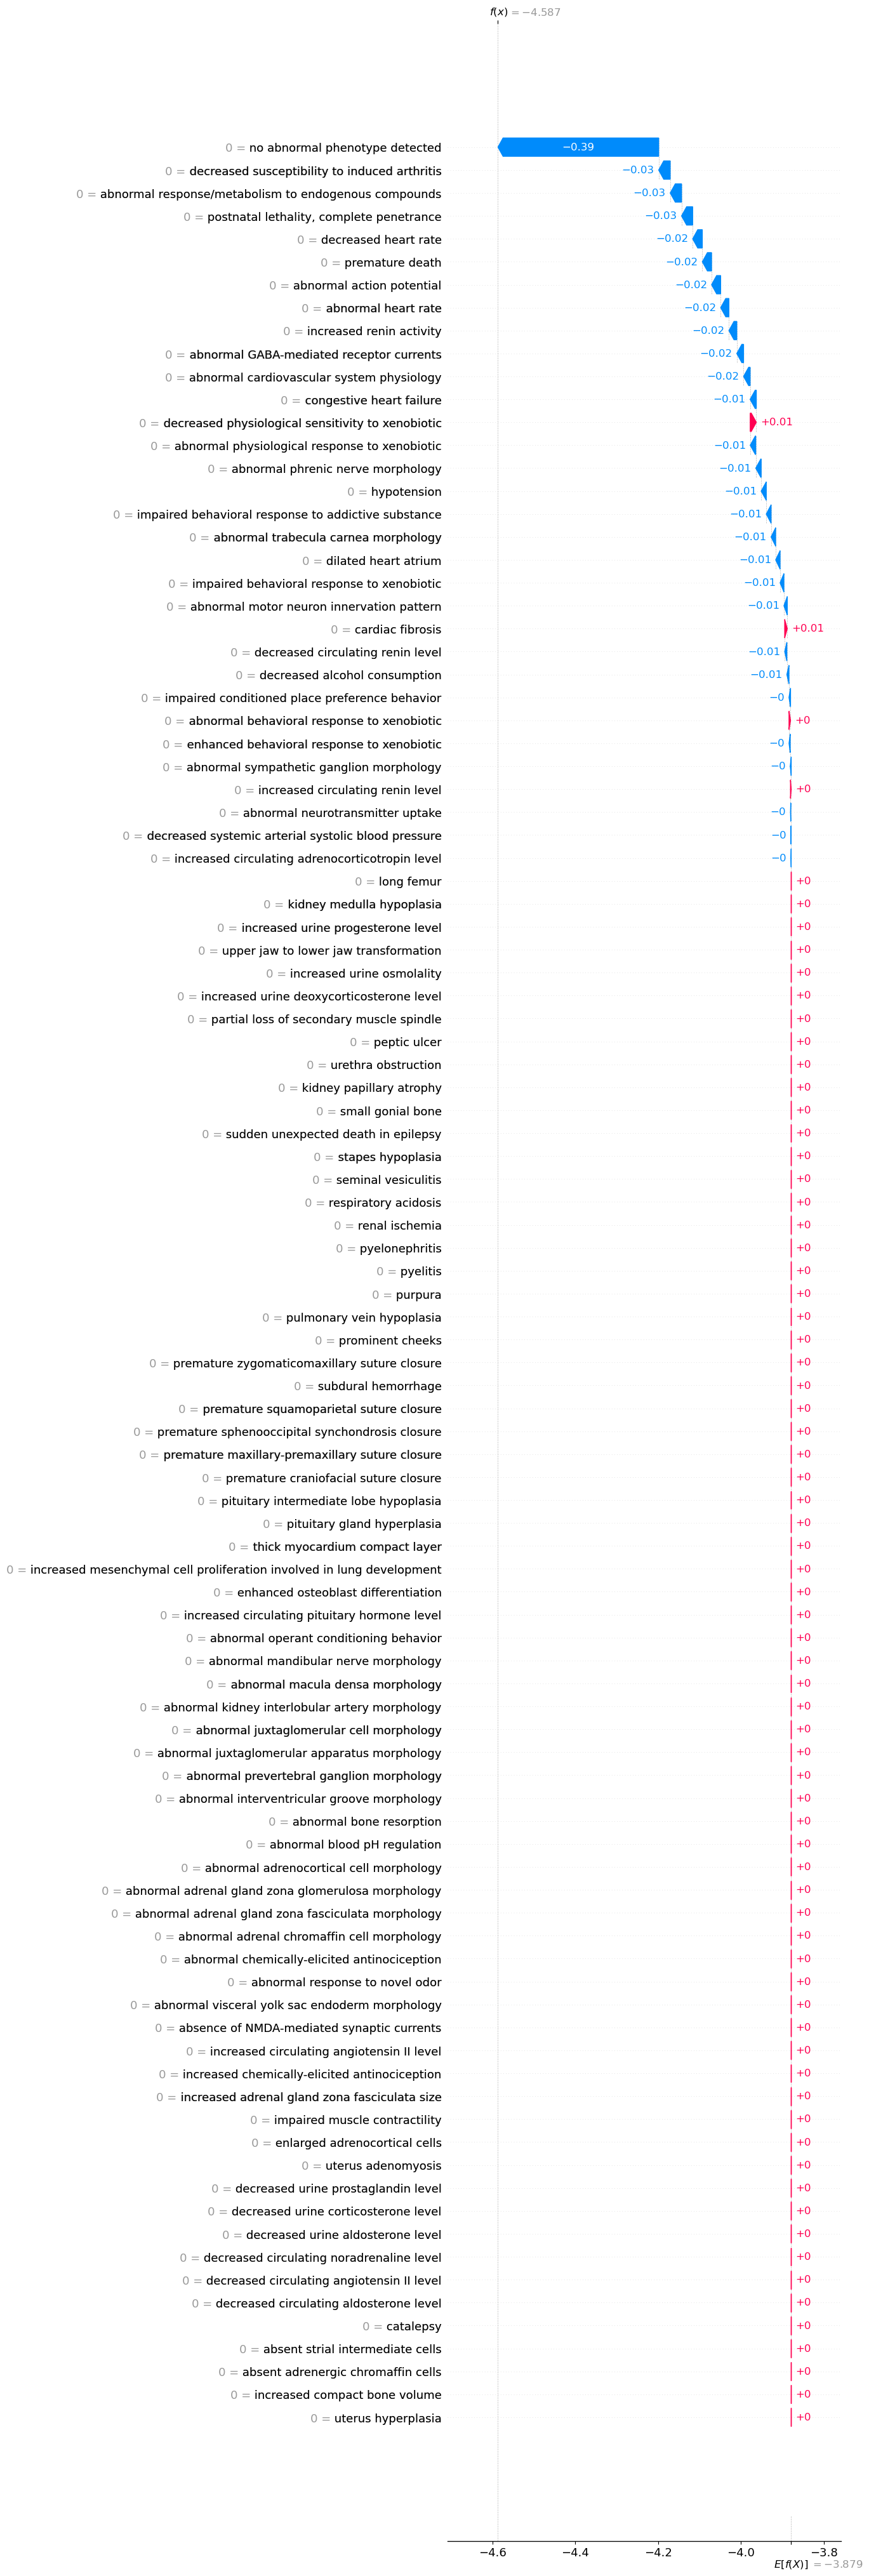

In [56]:
import shap

# Explain predictions using SHAP for XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_selected)

# Choose an observation to explain
observation_index = 0  # Select the observation index, e.g., the first row
shap_waterfall = shap_values[observation_index]

# Assign the feature names to the SHAP values object
shap_waterfall.feature_names = selected_feature_names  # Map top 100 feature names

# Generate the waterfall plot
shap.plots.waterfall(shap_waterfall, max_display=100)  # Display up to 100 features

In [31]:
#####
###

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [32]:
###
explainer

NameError: name 'explainer' is not defined